# MC-CP Supplementary Code

Dear reviewer,
In this notebook you can find all of the supplementary code behind our method, MC-CP. 🙂

## Misc (Imports, generic functions, etc.)

This section is full of various imports that are needed throughout our tests, as well as functions that are used in most test sections. Unique code/functions that are unique to a specific test can be found under that test.



In [ ]:
import keras
from keras.datasets import mnist, fashion_mnist, cifar10, cifar100, boston_housing
from keras.models import Model
import numpy as np
import pandas as pd
import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import StandardScaler
import random
from collections import Counter
from keras import applications
import tensorflow as tf
import os
from IPython.display import Image, display
from keras.utils import load_img
from PIL import ImageOps

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def load_cifar10():
  (x_train, y_train), (x_test, y_test) = cifar10.load_data()
  x_train = x_train.reshape(x_train.shape[0], 32, 32, 3)
  x_test = x_test.reshape(x_test.shape[0], 32, 32, 3)
  y_train = keras.utils.to_categorical(y_train, 10)
  y_test = keras.utils.to_categorical(y_test, 10)
  input_shape = (32, 32, 3)
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  x_train /= 255
  x_test /= 255
  return x_train, y_train, x_test, y_test, input_shape

In [ ]:
def load_cifar100():
  (x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode="fine")
  x_train = x_train.reshape(x_train.shape[0], 32, 32, 3)
  x_test = x_test.reshape(x_test.shape[0], 32, 32, 3)
  y_train = keras.utils.to_categorical(y_train, 100)
  y_test = keras.utils.to_categorical(y_test, 100)
  input_shape = (32, 32, 3)
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  x_train /= 255
  x_test /= 255
  return x_train, y_train, x_test, y_test, input_shape

In [ ]:
def load_mnist():
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
  x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
  y_train = keras.utils.to_categorical(y_train, 10)
  y_test = keras.utils.to_categorical(y_test, 10)
  input_shape = (28, 28, 1)
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  x_train /= 255
  x_test /= 255
  return x_train, y_train, x_test, y_test, input_shape

In [ ]:
def load_fashion_mnist():
  (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
  x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
  x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
  y_train = keras.utils.to_categorical(y_train, 10)
  y_test = keras.utils.to_categorical(y_test, 10)
  input_shape = (28, 28, 1)
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  x_train /= 255
  x_test /= 255
  return x_train, y_train, x_test, y_test, input_shape

In [ ]:
def load_tiny_imagenet():
  dataset = load_dataset("zh-plus/tiny-imagenet")
  train = dataset['train']
  x_train = [x['image'] for x in train]
  x_train = [img_to_array(x) for x in x_train]
  y_train = [x['label'] for x in train]
  test = dataset['valid']
  x_test = [x['image'] for x in test]
  x_test = [img_to_array(x) for x in x_test]
  y_test = [x['label'] for x in test]

  culledx_train = [ind for ind, x in enumerate(x_train) if x.shape != (64, 64, 3)]
  x_train = [x for x in x_train if x.shape == (64, 64, 3)]
  for index in sorted(culledx_train, reverse=True):
    del y_train[index]

  culledx_test = [ind for ind, x in enumerate(x_test) if x.shape != (64, 64, 3)]
  x_test = [x for x in x_test if x.shape == (64, 64, 3)]
  for index in sorted(culledx_test, reverse=True):
    del y_test[index]

  x_train, x_test = np.asarray(x_train), np.asarray(x_test)
  y_train, y_test = np.asarray(y_train), np.asarray(y_test)
  x_train = x_train.reshape(x_train.shape[0], 64, 64, 3)
  x_test = x_test.reshape(x_test.shape[0], 64, 64, 3)
  y_train = keras.utils.to_categorical(y_train, 200)
  y_test = keras.utils.to_categorical(y_test, 200)
  input_shape = (64, 64, 3)
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  x_train /= 255
  x_test /= 255

  return x_train, y_train, x_test, y_test, input_shape

In [ ]:
def load_housing_prices():
  (x_train, y_train), (x_test, y_test) = boston_housing.load_data(path="boston_housing.npz", test_split=0.2, seed=64)
  input_shape = x_train.shape[1]
  x_train = np.asarray(x_train)
  y_train = np.asarray(y_train)
  x_test = np.asarray(x_test)
  y_test = np.asarray(y_test)
  n_train = x_train.shape[0]
  in_shape = x_train.shape[1]

  idx = np.random.permutation(n_train)
  n_half = int(np.floor(n_train/2))
  idx_train, idx_cal = idx[:n_half], idx[n_half:2*n_half]

  scalerX = StandardScaler()
  scalerX = scalerX.fit(x_train[idx_train])

  x_train = scalerX.transform(x_train)
  x_test = scalerX.transform(x_test)

  mean_y_train = np.mean(np.abs(y_train[idx_train]))
  y_train = np.squeeze(y_train)/mean_y_train
  y_test = np.squeeze(y_test)/mean_y_train

  return x_train, y_train, x_test, y_test, idx_train, idx_cal, input_shape

In [ ]:
def load_blog_feedback():
  dataset = load_dataset("wwydmanski/blog-feedback")
  train = pd.DataFrame(data=dataset['train'])
  test = pd.DataFrame(data=dataset['test'])

  y_train = train['target']
  del train['target']
  y_test = test['target']
  del test['target']

  x_train = np.asarray(train)
  y_train = np.asarray(y_train)
  x_test = np.asarray(test)
  y_test = np.asarray(y_test)
  input_shape = x_train.shape[1]

  n_train = x_train.shape[0]
  idx = np.random.permutation(n_train)
  n_half = int(np.floor(n_train/2))
  idx_train, idx_cal = idx[:n_half], idx[n_half:2*n_half]

  scaler = StandardScaler()
  scaler.fit(x_train[idx_train])

  x_train = scaler.transform(x_train)
  x_test = scaler.transform(x_test)

  mean_y_train = np.mean(np.abs(y_train[idx_train]))
  y_train = np.squeeze(y_train)/mean_y_train
  y_test = np.squeeze(y_test)/mean_y_train

  return x_train, x_test, y_train, y_test, input_shape

In [ ]:
def load_concrete():
  column_names = ["Cement", "Blast Furnace Slag", "Fly Ash", "Water", "Superplasticizer", "Coarse Aggregate",
                  "Fine Aggregate", "Age", "Concrete compressive strength"]
  data = pd.read_csv('Concrete_Data.csv', names=column_names)
  data.drop(index = data.index[0], axis=0, inplace=True)

  y = data['Concrete compressive strength'].astype(float)
  del data['Concrete compressive strength']
  x = data.astype(float)
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

  x_train = np.asarray(x_train)
  y_train = np.asarray(y_train)
  x_test = np.asarray(x_test)
  y_test = np.asarray(y_test)
  input_shape = x_train.shape[1]

  n_train = x_train.shape[0]
  idx = np.random.permutation(n_train)
  n_half = int(np.floor(n_train/2))
  idx_train, idx_cal = idx[:n_half], idx[n_half:2*n_half]

  scaler = StandardScaler()
  scaler.fit(x_train[idx_train])

  x_train = scaler.transform(x_train)
  x_test = scaler.transform(x_test)

  mean_y_train = np.mean(np.abs(y_train[idx_train]))
  y_train = np.squeeze(y_train)/mean_y_train
  y_test = np.squeeze(y_test)/mean_y_train

  return x_train, x_test, y_train, y_test, input_shape

In [ ]:
def load_abalone():
  # load data
  column_names = ["sex", "length", "diameter", "height", "whole weight",
                "shucked weight", "viscera weight", "shell weight", "rings"]
  data = pd.read_csv('abalone.data.csv', names=column_names)

  # change string to boolean
  for label in "MFI":
    data[label] = data["sex"] == label
  del data["sex"]

  y = data.rings.values.astype(float)
  del data['rings']
  x = data.values.astype(float)

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
  x_train = np.asarray(x_train)
  y_train = np.asarray(y_train)
  x_test = np.asarray(x_test)
  y_test = np.asarray(y_test)
  input_shape = x_train.shape[1]


  n_train = x_train.shape[0]
  idx = np.random.permutation(n_train)
  n_half = int(np.floor(n_train/2))
  idx_train, idx_cal = idx[:n_half], idx[n_half:2*n_half]

  scaler = StandardScaler()
  scaler.fit(x_train[idx_train])

  x_train = scaler.transform(x_train)
  x_test = scaler.transform(x_test)

  mean_y_train = np.mean(np.abs(y_train[idx_train]))
  y_train = np.squeeze(y_train)/mean_y_train
  y_test = np.squeeze(y_test)/mean_y_train

  return x_train, x_test, y_train, y_test, input_shape

In [ ]:
def dropout_layer(input, percent, montecarlo):
  if montecarlo:
    return keras.layers.Dropout(percent)(input, training=True)
  else:
    return keras.layers.Dropout(percent)(input)

def cnn_model(montecarlo, activation, input_shape, output_dims):
  input_layer = keras.layers.Input(input_shape)
  layer1A = keras.layers.Conv2D(32, (3, 3), activation=activation)(input_layer)
  pooling1 = keras.layers.MaxPooling2D((2, 2))(layer1A)
  dropout1 = dropout_layer(pooling1, 0.5, montecarlo)

  layer1B = keras.layers.Conv2D(64, (3, 3), activation=activation)(dropout1)
  pooling2 = keras.layers.MaxPooling2D((2, 2))(layer1B)
  dropout2 = dropout_layer(pooling2, 0.5, montecarlo)

  flatten_layer = keras.layers.Flatten()(dropout2)
  dense1 = keras.layers.Dense(128, activation=activation)(flatten_layer)
  output_layer = keras.layers.Dense(output_dims, activation='softmax')(dense1)

  model = Model(inputs=input_layer, outputs=output_layer)
  model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                metrics=['accuracy'])
  return model

In [ ]:
"""
Our dynamic MC method
Params:
  x_test -> a testing dataset to produce predictions on
  model -> a model to predict with
  patience -> how many forward passes to wait when all classes are lower than
  the min_delta threshold
  min_delta -> the threshold a class how to be lower than to be considered stable
  max_mc -> the maximum number of forward passes if the classes never converge

Returns:
  A set of predictions
"""
def dynamic_mc_predict(x_test, model, patience, min_delta, max_mc):
  montecarlo_predictions = []
  var_diffs = []
  for data in tqdm.tqdm(x_test):
    current_patience_count = 0
    prev_variance = []
    predictions = []
    while True:
      prediction = model.predict(np.expand_dims(data, axis=0), verbose=0)
      predictions.append(prediction)
      variance = np.asarray(predictions).std(axis=0)
      if len(predictions) != 1:
        var_diff = abs(np.subtract(prev_variance, variance))
        var_diffs.append(var_diff)
        if np.all(var_diff <= min_delta) == True:
          current_patience_count +=1
        else:
          current_patience_count = 0
      if current_patience_count > patience or len(predictions) == max_mc:
        break
      prev_variance = variance
    predictions = np.squeeze(predictions)
    montecarlo_predictions.append(np.asarray(predictions).mean(axis=0))
  return montecarlo_predictions

In [ ]:
"""
Only difference here is we format the predictions into the final array to work nicely with a quantile regressor
"""
def dynamic_mc_predict_reg(x_test, model, patience, min_delta, max_mc):
  montecarlo_predictions = []
  var_diffs = []
  for data in tqdm.tqdm(x_test):
    current_patience_count = 0
    prev_variance = []
    predictions = []
    while True:
      prediction = model.predict(np.expand_dims(data, axis=0), verbose=0)
      predictions.append(prediction)
      variance = np.array(predictions).std(axis=0)
      if len(predictions) != 1:
        var_diff = abs(np.subtract(prev_variance, variance))
        var_diffs.append(var_diff)
        if np.all(var_diff <= min_delta) == True:
          current_patience_count +=1
        else:
          current_patience_count = 0
      if current_patience_count > patience or len(predictions) == max_mc:
        break
      prev_variance = variance
    predictions = np.asarray(predictions).mean(axis=0)
    predictions = np.reshape(predictions, predictions.shape[0:2])
    montecarlo_predictions.append(predictions)
  montecarlo_predictions = np.asarray(montecarlo_predictions)
  return montecarlo_predictions

## Test Dynamic MC Once

In [ ]:
def dynamic_mc(x_train, y_train, x_test, y_test, output_dims):
  model = cnn_model(montecarlo=True, activation='relu', input_shape=input_shape, output_dims=output_dims)
  history = model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1)

  # dynamic mc
  patience = 10
  min_delta = 5e-4
  max_mc = 1000
  montecarlo_predictions = []
  var_diffs = []
  for image in tqdm.tqdm(x_test):
    current_patience_count = 0
    prev_variance = []
    predictions = []
    while True:
      prediction = model.predict(np.expand_dims(image, axis=0), verbose=0)
      predictions.append(prediction)
      variance = np.array(predictions).std(axis=0)
      if len(predictions) != 1:
        var_diff = abs(np.subtract(prev_variance, variance))
        var_diffs.append(var_diff)
        if np.all(var_diff <= min_delta) == True:
          current_patience_count +=1
        else:
          current_patience_count = 0
      if current_patience_count > patience or len(predictions) == max_mc:
        break
      prev_variance = variance
    montecarlo_predictions.append(np.array(predictions).mean(axis=0))
  return var_diffs

170498071/170498071 [==============================] - 5s 0us/step
ship


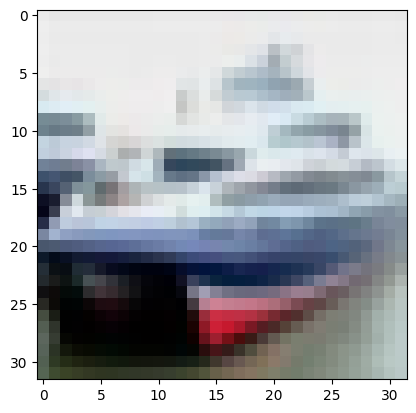

In [ ]:
# load dataset
x_train, y_train, x_test, y_test, input_shape = load_cifar10()
# convert to readable class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
y_test_new = np.array([np.argmax(y, axis=None, out=None) for y in y_test])

# show example image and its corresponding label
plt.imshow(x_test[1])
true_label = int(y_test_new[1])
print(class_names[true_label])

In [ ]:
var_diff = dynamic_mc(x_train, y_train, x_test[1:2], y_test[1:2], output_dims=10)

Epoch 1/10
391/391 [==============================] - 17s 5ms/step - loss: 1.9997 - accuracy: 0.2574
Epoch 2/10
391/391 [==============================] - 2s 5ms/step - loss: 1.6146 - accuracy: 0.4131
Epoch 3/10
391/391 [==============================] - 2s 4ms/step - loss: 1.4613 - accuracy: 0.4742
Epoch 4/10
391/391 [==============================] - 2s 6ms/step - loss: 1.3758 - accuracy: 0.5073
Epoch 5/10
391/391 [==============================] - 2s 5ms/step - loss: 1.3195 - accuracy: 0.5272
Epoch 6/10
391/391 [==============================] - 2s 5ms/step - loss: 1.2588 - accuracy: 0.5505
Epoch 7/10
391/391 [==============================] - 2s 5ms/step - loss: 1.2202 - accuracy: 0.5644
Epoch 8/10
391/391 [==============================] - 2s 5ms/step - loss: 1.1813 - accuracy: 0.5809
Epoch 9/10
391/391 [==============================] - 2s 5ms/step - loss: 1.1593 - accuracy: 0.5893
Epoch 10/10
391/391 [==============================] - 2s 5ms/step - loss: 1.1267 - accuracy: 0.599

100%|██████████| 1/1 [00:19<00:00, 19.10s/it]


In [ ]:
class0_diff = [x[0][0] for x in var_diff]
class1_diff = [x[0][1] for x in var_diff]
class2_diff = [x[0][2] for x in var_diff]
class3_diff = [x[0][3] for x in var_diff]
class4_diff = [x[0][4] for x in var_diff]
class5_diff = [x[0][5] for x in var_diff]
class6_diff = [x[0][6] for x in var_diff]
class7_diff = [x[0][7] for x in var_diff]
class8_diff = [x[0][8] for x in var_diff]
class9_diff = [x[0][9] for x in var_diff]

In [ ]:
x = list(range(0, len(var_diff)))
plt.plot(x, class0_diff, label='Airplane')
plt.plot(x, class1_diff, label='Automobile')
plt.plot(x, class2_diff, label='Bird')
plt.plot(x, class3_diff, label='Cat')
plt.plot(x, class4_diff, label='Deer')
plt.plot(x, class5_diff, label='Dog')
plt.plot(x, class6_diff, label='Frog')
plt.plot(x, class7_diff, label='Horse')
plt.plot(x, class8_diff, label='Ship')
plt.plot(x, class9_diff, label='Truck')

plt.axhline(y=5e-4, color='r', label="Delta", linestyle='--')
plt.ylabel("Difference in Variance")
plt.xlabel("Ensemble No.")
plt.legend()

## Test Dynamic MC Once for Regression

In [ ]:
class MultiQuantileLoss(tf.keras.losses.Loss):

    def __init__(self, quantiles:list, **kwargs):
        super(MultiQuantileLoss, self).__init__(**kwargs)

        self.quantiles = quantiles

    def call(self, y_true, y_pred):

        # get quantile value
        q_id = int(y_pred.name.split("/")[1][1:])
        q = self.quantiles[q_id]

        # minimize quantile error
        q_error = tf.subtract(y_true, y_pred)
        q_loss = tf.reduce_mean(tf.maximum(q*q_error, (q-1)*q_error), axis=-1)
        return q_loss

def build_mqnn(quantiles:list, training_x_values:np.ndarray, internal_nodes:list = [32, 32], montecarlo=False,
               model_name:str = "mqnn", optimizer=None, input_normalization:bool = True):
    input_dim = training_x_values.shape[1]
    output_dim = len(quantiles)

    # define normalizer
    normalizer = tf.keras.layers.Normalization()
    normalizer.adapt(training_x_values)

    # build model's node structure
    inputs = keras.layers.Input(shape=input_dim)
    mdl = normalizer(inputs)
    for n_nodes in internal_nodes:
        mdl = keras.layers.Dense(n_nodes, activation='relu')(mdl)
        mdl = keras.layers.Dropout(0.25)(mdl, training=montecarlo)
    outputs = [keras.layers.Dense(1, activation='linear', name="q%d" % q_i)(mdl) for q_i in range(output_dim)]
    del input_dim, output_dim, mdl, normalizer

    # define optimizer and loss functions
    optm_func = tf.optimizers.Adam(learning_rate=0.001) if optimizer is None else optimizer
    loss_func = MultiQuantileLoss(quantiles=quantiles)

    # build and compile model
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name=model_name)
    model.compile(optimizer=optm_func, loss=loss_func, metrics=['mae'])

    return model

In [ ]:
def dynamic_mc(x_train, y_train, x_test, y_test):
  quantiles = [0.05, 0.95]
  model = build_mqnn(quantiles, x_train, [128, 128], montecarlo=True)
  history = model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=1)

  # dynamic mc
  patience = 10
  min_delta = 5e-4
  max_mc = 1000
  montecarlo_predictions = []
  var_diffs = []
  for dp in tqdm.tqdm(x_test):
    current_patience_count = 0
    prev_variance = []
    predictions = []
    while True:
      prediction = model.predict(dp, verbose=0)
      predictions.append(prediction)
      variance = np.array(predictions).std(axis=0)
      if len(predictions) != 1:
        var_diff = abs(np.subtract(prev_variance, variance))
        var_diffs.append(var_diff)
        if np.all(var_diff <= min_delta) == True:
          current_patience_count +=1
        else:
          current_patience_count = 0
      if current_patience_count > patience or len(predictions) == max_mc:
        break
      prev_variance = variance
    montecarlo_predictions.append(np.array(predictions).mean(axis=0))
  return var_diffs

In [ ]:
# load dataset
x_train, y_train, x_test, y_test, idx_train, idx_cal, input_shape = load_housing_prices()

# show example dp and its corresponding true value
print(x_test[0])
print(y_test[0])

In [ ]:
var_diff = dynamic_mc(x_train, y_train, x_test[:1], y_test[:1])

In [ ]:
quantup_diff = [x[0][0][0] for x in var_diff]
quantlow_diff = [x[1][0][0] for x in var_diff]

In [ ]:
x = list(range(0, len(var_diff)))
plt.plot(x, quantup_diff, label='95%')
plt.plot(x, quantlow_diff, label='5%')


plt.axhline(y=5e-4, color='r', label="Delta", linestyle='--')
plt.ylabel("Difference in Variance")
plt.xlabel("Ensemble No.")
plt.legend()

## Produce test errors

This section reproduces the table that showcases the test errors for each method on each dataset

### Functions

Here are a set of unique functions that are only needed in the test section.

In [ ]:
def test_error_baseline(iterations, x_train, y_train, x_test, y_test, output_dims):
  test_errors = []
  for n in range(iterations):
    model = cnn_model(montecarlo=False, activation='relu', input_shape=input_shape, output_dims=output_dims)
    history = model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1)
    score = model.evaluate(x_test, y_test, verbose=0)
    test_accuracy = score[1]
    test_error = 1 - test_accuracy
    test_errors.append(test_error)
  print("Test error: {:2f}, +/-{:2f}".format(np.mean(test_errors), np.std(test_errors)))
  return test_errors

In [ ]:
def test_error_mc(iterations, x_train, y_train, x_test, y_test, output_dims):
  test_errors = []
  for n in range(iterations):
    model = cnn_model(montecarlo=True, activation='relu', input_shape=input_shape, output_dims=output_dims)
    history = model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1)
    montecarlo_predictions = []
    for i in tqdm.tqdm(range(1000)):
      prediction = model.predict(x_test, batch_size=1000, verbose=0)
      montecarlo_predictions.append(prediction)

    # predictions
    acc = 0
    for idx in tqdm.tqdm(range(len(x_test))):
      softmaxes = np.array([p[idx] for p in montecarlo_predictions])
      prediction = softmaxes.mean(axis=0).argmax()
      true_label = np.where(y_test[idx])[0]

      if prediction == true_label:
        acc += 1

    test_accuracy = acc / len(x_test)
    test_error = 1 - test_accuracy
    test_errors.append(test_error)
  print("Test error: {:2f}, +/-{:2f}".format(np.mean(test_errors), np.std(test_errors)))
  return test_errors

In [ ]:
def test_error_naive(iterations, x_train, y_train, x_test, y_test, output_dims):
  test_errors = []
  for n in range(iterations):
    model = cnn_model(montecarlo=False, activation='relu', input_shape=input_shape, output_dims=output_dims)
    history = model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1)
    predictions = model.predict(x_test, batch_size=1000)

    # calibration
    n = 2500
    alpha = 0.05
    y_test_new = np.array([np.argmax(y, axis=None, out=None) for y in y_test])

    idx = np.array([1] * n + [0] * (predictions.shape[0] - n)) > 0
    np.random.shuffle(idx)
    cal_softmax, val_softmax = predictions[idx, :], predictions[~idx, :]
    cal_labels, val_labels = y_test_new[idx], y_test_new[~idx]

    cal_scores = 1 - cal_softmax[np.arange(n), cal_labels]

    q_level = np.ceil((n + 1) * (1 - alpha)) / n
    q_hat = np.quantile(cal_scores, q_level, method="higher")
    pred_sets = val_softmax >= (1 - q_hat)

    # predictions
    acc = 0
    for idx in range(len(val_softmax)):
      softmax = val_softmax[idx]
      preds = softmax > 1 - q_hat
      label_set = np.where(preds)[0]
      true_label = np.where(val_labels[idx])[0]

      if true_label in label_set:
        acc += 1

    test_accuracy = acc / len(x_test)
    test_error = 1 - test_accuracy
    test_errors.append(test_error)
  print("Test error: {:2f}, +/-{:2f}".format(np.mean(test_errors), np.std(test_errors)))
  return test_errors

In [ ]:
def test_error_raps(iterations, x_train, y_train, x_test, y_test, output_dims):
  test_errors = []
  for n in range(iterations):
    model = cnn_model(montecarlo=False, activation='relu', input_shape=input_shape, output_dims=output_dims)
    history = model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1)
    predictions = model.predict(x_test, batch_size=1000)
    print(predictions.shape)

    # calibration
    n = 2500
    alpha = 0.05
    y_test_new = np.array([np.argmax(y, axis=None, out=None) for y in y_test])
    lam_reg = 0.01
    k_reg = 5
    disallow_zero_sets = False
    rand = False
    reg_vec = np.array(k_reg * [0,] + (predictions.shape[1] - k_reg) * [lam_reg,])[None,:]

    idx = np.array([1] * n + [0] * (predictions.shape[0] - n)) > 0
    np.random.shuffle(idx)
    cal_softmax, val_softmax = predictions[idx, :], predictions[~idx, :]
    cal_labels, val_labels = y_test_new[idx], y_test_new[~idx]

    cal_pi = cal_softmax.argsort(1)[:,::-1]
    cal_srt = np.take_along_axis(cal_softmax, cal_pi, axis=1)
    cal_srt_reg = cal_srt + reg_vec
    cal_L = np.where(cal_pi == cal_labels[:, None])[1]
    cal_scores = cal_srt_reg.cumsum(axis=1)[np.arange(n), cal_L] - np.random.rand(n) * cal_srt_reg[np.arange(n), cal_L]

    q_level = np.ceil((n + 1) * (1 - alpha)) / n
    q_hat = np.quantile(cal_scores, q_level, method="higher")

    # predictions
    acc = 0
    for idx in range(len(val_softmax)):
      softmax = val_softmax[idx]
      _pi = np.argsort(softmax)[::-1]
      _srt = np.take_along_axis(softmax, _pi, axis=0)
      _srt_reg = _srt + reg_vec.squeeze()
      _srt_reg_cumsum = _srt_reg.cumsum()
      _ind = (_srt_reg_cumsum - np.random.rand() * _srt_reg) <= q_hat if rand else _srt_reg_cumsum - _srt_reg <= q_hat
      if disallow_zero_sets: _ind[0] = True
      pred_set = np.take_along_axis(_ind, _pi.argsort(), axis=0)
      label_set = np.where(pred_set)[0]
      true_label = np.where(val_labels[idx])[0]

      if true_label in label_set:
        acc += 1

    test_accuracy = acc / len(x_test)
    test_error = 1 - test_accuracy
    test_errors.append(test_error)
  print("Test error: {:2f}, +/-{:2f}".format(np.mean(test_errors), np.std(test_errors)))
  return test_errors

In [ ]:
def test_error_mcraps(iterations, x_train, y_train, x_test, y_test, output_dims):
  test_errors = []
  for n in range(iterations):
    model = cnn_model(montecarlo=True, activation='relu', input_shape=input_shape, output_dims=output_dims)
    history = model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1)

    montecarlo_predictions = np.asarray(dynamic_mc_predict(x_test, model, 10, 5e-4, 1000))

    # calibration
    n = 2500
    alpha = 0.05
    y_test_new = np.array([np.argmax(y, axis=None, out=None) for y in y_test])
    lam_reg = 0.01
    k_reg = 5
    disallow_zero_sets = False
    rand = False
    reg_vec = np.array(k_reg * [0,] + (montecarlo_predictions.shape[1] - k_reg) * [lam_reg,])[None,:]

    idx = np.array([1] * n + [0] * (montecarlo_predictions.shape[0] - n)) > 0
    np.random.shuffle(idx)
    cal_softmax, val_softmax = montecarlo_predictions[idx, :], montecarlo_predictions[~idx, :]
    cal_labels, val_labels = y_test_new[idx], y_test_new[~idx]

    cal_pi = cal_softmax.argsort(1)[:,::-1]
    cal_srt = np.take_along_axis(cal_softmax, cal_pi, axis=1)
    cal_srt_reg = cal_srt + reg_vec
    cal_L = np.where(cal_pi == cal_labels[:, None])[1]
    cal_scores = cal_srt_reg.cumsum(axis=1)[np.arange(n), cal_L] - np.random.rand(n) * cal_srt_reg[np.arange(n), cal_L]

    q_level = np.ceil((n + 1) * (1 - alpha)) / n
    q_hat = np.quantile(cal_scores, q_level, method="higher")

    # predictions
    acc = 0
    for idx in range(len(val_softmax)):
      _softmax = val_softmax[idx]
      _pi = np.argsort(_softmax)[::-1]
      _srt = np.take_along_axis(_softmax, _pi, axis=0)
      _srt_reg = _srt + reg_vec.squeeze()
      _srt_reg_cumsum = _srt_reg.cumsum()
      _ind = (_srt_reg_cumsum - np.random.rand() * _srt_reg) <= q_hat if rand else _srt_reg_cumsum - _srt_reg <= q_hat
      if disallow_zero_sets: _ind[0] = True
      pred_set = np.take_along_axis(_ind, _pi.argsort(), axis=0)
      label_set = np.where(pred_set)[0]
      true_label = np.where(val_labels[idx])[0]

      if true_label in label_set:
        acc += 1

    test_accuracy = acc / len(x_test)
    test_error = 1 - test_accuracy
    test_errors.append(test_error)
  print("Test error: {:2f}, +/-{:2f}".format(np.mean(test_errors), np.std(test_errors)))
  return test_errors

### Tests

Here are the test outputs for each dataset, as well as some plots when needed.

#### CIFAR-10

In [ ]:
x_train, y_train, x_test, y_test, input_shape = load_cifar10()
reg_test_error = test_error_baseline(5, x_train, y_train, x_test, y_test, output_dims=10)

In [ ]:
x_train, y_train, x_test, y_test, input_shape = load_cifar10()
mc_test_error = test_error_mc(5, x_train, y_train, x_test, y_test, output_dims=10)

In [ ]:
x_train, y_train, x_test, y_test, input_shape = load_cifar10()
naive_test_error = test_error_naive(5, x_train, y_train, x_test, y_test, output_dims=10)

In [ ]:
x_train, y_train, x_test, y_test, input_shape = load_cifar10()
raps_test_error = test_error_raps(1, x_train, y_train, x_test, y_test, output_dims=10)

In [ ]:
x_train, y_train, x_test, y_test, input_shape = load_cifar10()
mcraps_test_error = test_error_mcraps(1, x_train, y_train, x_test[:20], y_test[:20], output_dims=10)

391/391 [==============================] - 3s 5ms/step - loss: 1.9635 - accuracy: 0.2766


100%|██████████| 20/20 [00:05<00:00,  3.86it/s]


ValueError: ignored

#### CIFAR-10 Boxplot


In [ ]:
a1 = [i * 100 for i in reg_test_error]
a2 = [i * 100 for i in mc_test_error]
a3 = [i * 100 for i in naive_test_error]
a4 = [i * 100 for i in raps_test_error]
a5 = [i * 100 for i in mcraps_test_error]
data = [a3, a4, a5]

labels = ['Naive', 'RAPS', 'MC-CP']

fig, ax = plt.subplots()
bp = ax.boxplot(data, labels=labels, patch_artist = True,
                medianprops = dict(color = "black"), vert=False)

bp['boxes'][0].set_facecolor('salmon')
bp['boxes'][1].set_facecolor('gold')
bp['boxes'][2].set_facecolor('limegreen')

ax.set_xlabel("Test Error %")
ax.set_title("CIFAR10 Mean Test Error")

In [ ]:
a1 = [i * 100 for i in reg_test_error]
a2 = [i * 100 for i in mc_test_error]
a3 = [i * 100 for i in naive_test_error]
a4 = [i * 100 for i in raps_test_error]
a5 = [i * 100 for i in mcraps_test_error]
data = [a1, a2, a3, a4, a5]

labels = ['Baseline', 'MC', 'Naive', 'RAPS', 'MC-CP']

fig, ax = plt.subplots()
ax.boxplot(data, labels=labels, vert=False)
ax.set_ylabel("Test Error %")
ax.set_title("CIFAR10 Mean Test Error")

## Deep Quantile Regressor

Here are the various functions and tests for the regression section of our paper.

### Functions

In [ ]:
class MultiQuantileLoss(tf.keras.losses.Loss):
    def __init__(self, quantiles:list, **kwargs):
        super(MultiQuantileLoss, self).__init__(**kwargs)

        self.quantiles = quantiles

    def call(self, y_true, y_pred):

        # get quantile value
        q_id = int(y_pred.name.split("/")[1][1:])
        q = self.quantiles[q_id]

        # minimize quantile error
        q_error = tf.subtract(y_true, y_pred)
        q_loss = tf.reduce_mean(tf.maximum(q*q_error, (q-1)*q_error), axis=-1)
        return q_loss

In [ ]:
def build_mqnn(quantiles:list, training_x_values:np.ndarray, internal_nodes:list = [32, 32], montecarlo=False,
               model_name:str = "mqnn", optimizer=None, input_normalization:bool = True):

    input_dim = training_x_values.shape[1]
    output_dim = len(quantiles)

    # define normalizer
    normalizer = tf.keras.layers.Normalization()
    normalizer.adapt(training_x_values)

    # build model's node structure
    inputs = keras.layers.Input(shape=input_dim)
    mdl = normalizer(inputs)
    for i, n_nodes in enumerate(internal_nodes):
        mdl = keras.layers.Dense(n_nodes, activation='relu')(mdl)
        if i != (len(internal_nodes) - 1):
          mdl = keras.layers.Dropout(0.1)(mdl, training=montecarlo)
    outputs = [keras.layers.Dense(1, activation='linear', name="q%d" % q_i)(mdl) for q_i in range(output_dim)]
    del input_dim, output_dim, mdl, normalizer

    # define optimizer and loss functions
    optm_func = tf.optimizers.Adam(learning_rate=0.001) if optimizer is None else optimizer
    loss_func = MultiQuantileLoss(quantiles=quantiles)

    # build and compile model
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name=model_name)
    model.compile(optimizer=optm_func, loss=loss_func, metrics=['mae'])

    return model

In [ ]:
def regression_test_mae_regular(iterations, x_train, y_train, x_test, y_test):
  test_maes = []
  quantiles = [0.05, 0.95]
  for n in range(iterations):
    model = build_mqnn(quantiles, x_train, [128, 128], False)
    history = model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)
    prediction = model.predict(x_test, batch_size=1000, verbose=0)

    upper_preds = []
    lower_preds = []
    # predictions
    for idx in tqdm.tqdm(range(len(x_test))):
      upper_pred = prediction[1][idx]
      lower_pred = prediction[0][idx]
      true_label = y_test[idx]

      upper_preds.append(upper_pred)
      lower_preds.append(lower_pred)

    upper_mae = mae(y_test, upper_preds)
    lower_mae = mae(y_test, lower_preds)
    full_mae = upper_mae + lower_mae
    test_maes.append(full_mae)

  print("Test MAE: {:2f}, +/-{:2f}".format(np.mean(test_maes), np.std(test_maes)))

In [ ]:
def regression_test_mae_mc(iterations, x_train, y_train, x_test, y_test):
  test_maes = []
  quantiles = [0.05, 0.95]
  for n in range(iterations):
    model = build_mqnn(quantiles, x_train, [128, 128], True)
    history = model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)
    montecarlo_predictions = []
    for i in tqdm.tqdm(range(500)):
      prediction = model.predict(x_test, batch_size=1000, verbose=0)
      prediction = np.asarray(prediction)
      prediction = np.reshape(prediction, prediction.shape[0:2])
      montecarlo_predictions.append(prediction)

    upper_preds = []
    lower_preds = []
    # predictions
    for idx in tqdm.tqdm(range(len(x_test))):
      pred_mean = np.mean(montecarlo_predictions, axis=0)
      upper_pred = pred_mean[1][idx]
      lower_pred = pred_mean[0][idx]
      true_label = y_test[idx]

      upper_preds.append(upper_pred)
      lower_preds.append(lower_pred)

    upper_mae = mae(y_test, upper_preds)
    lower_mae = mae(y_test, lower_preds)
    full_mae = upper_mae + lower_mae
    test_maes.append(full_mae)
  print("Test MAE: {:2f}, +/-{:2f}".format(np.mean(test_maes), np.std(test_maes)))

In [ ]:
def regression_test_mae_cqr(iterations, x_train, y_train, x_test, y_test):
  test_maes = []
  quantiles = [0.05, 0.95]
  uncal_cov = []
  cal_cov = []
  for n in range(iterations):
    model = build_mqnn(quantiles, x_train, [128, 128], False)
    history = model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)
    prediction = np.squeeze(np.asarray(model.predict(x_test, batch_size=1000, verbose=0)))

    # calibration
    n = 10
    alpha = 0.1

    idx = np.array([1] * n + [0] * (len(y_test) - n)) > 0
    np.random.shuffle(idx)
    cal_labels, val_labels = y_test[idx], y_test[~idx]
    cal_upper, val_upper = prediction[1][idx], prediction[1][~idx]
    cal_lower, val_lower = prediction[0][idx], prediction[0][~idx]

    cal_scores = np.maximum(cal_labels-cal_upper, cal_lower-cal_labels)
    qhat = np.quantile(cal_scores, np.ceil((n+1)*(1-alpha))/n, method='higher')

    prediction_sets = [val_lower - qhat, val_upper + qhat]

    # coverage
    prediction_sets_uncalibrated = [val_lower, val_upper]
    empirical_coverage_uncalibrated = ((val_labels >= prediction_sets_uncalibrated[0]) & (val_labels <= prediction_sets_uncalibrated[1])).mean()
    uncal_cov.append(empirical_coverage_uncalibrated)
    empirical_coverage = ((val_labels >= prediction_sets[0]) & (val_labels <= prediction_sets[1])).mean()
    cal_cov.append(empirical_coverage)

    upper_preds = []
    lower_preds = []
    # predictions
    for idx in tqdm.tqdm(range(len(val_lower))):
      upper_pred = prediction_sets[1][idx]
      lower_pred = prediction_sets[0][idx]
      true_label = val_labels[idx]

      upper_preds.append(upper_pred)
      lower_preds.append(lower_pred)

    upper_mae = mae(val_labels, upper_preds)
    lower_mae = mae(val_labels, lower_preds)
    full_mae = upper_mae + lower_mae
    test_maes.append(full_mae)

  print("Test MAE: {:2f}, +/-{:2f}".format(np.mean(test_maes), np.std(test_maes)))
  print("The empirical coverage before calibration is: {:2f}, +/-{:2f}".format(np.mean(uncal_cov), np.std(uncal_cov)))
  print("The empirical coverage after calibration is: {:2f}, +/-{:2f}".format(np.mean(cal_cov), np.std(cal_cov)))

In [ ]:
def regression_test_mae_mccqr(iterations, x_train, y_train, x_test, y_test):
  test_maes = []
  quantiles = [0.05, 0.95]
  uncal_cov = []
  cal_cov = []
  for n in range(iterations):
    model = build_mqnn(quantiles, x_train, [128, 128], True)
    history = model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)

    montecarlo_predictions = dynamic_mc_predict_reg(x_test, model, 10, 5e-4, 1000)

    # calibration
    n = 10
    alpha = 0.1

    idx = np.array([1] * n + [0] * (len(y_test) - n)) > 0
    np.random.shuffle(idx)
    cal_labels, val_labels = y_test[idx], y_test[~idx]
    cal_upper, val_upper = montecarlo_predictions[:,1][idx], montecarlo_predictions[:,1][~idx]
    cal_lower, val_lower = montecarlo_predictions[:,0][idx], montecarlo_predictions[:,0][~idx]

    cal_scores = np.maximum(cal_labels-cal_upper, cal_lower-cal_labels)
    qhat = np.quantile(cal_scores, np.ceil((n+1)*(1-alpha))/n, method='higher')

    prediction_sets = [val_lower - qhat, val_upper + qhat]

    # coverage
    prediction_sets_uncalibrated = [val_lower, val_upper]
    empirical_coverage_uncalibrated = ((val_labels >= prediction_sets_uncalibrated[0]) & (val_labels <= prediction_sets_uncalibrated[1])).mean()
    uncal_cov.append(empirical_coverage_uncalibrated)
    empirical_coverage = ((val_labels >= prediction_sets[0]) & (val_labels <= prediction_sets[1])).mean()
    cal_cov.append(empirical_coverage)

    upper_preds = []
    lower_preds = []
    # predictions
    for idx in tqdm.tqdm(range(len(val_lower))):
      upper_pred = prediction_sets[1][idx]
      lower_pred = prediction_sets[0][idx]
      true_label = val_labels[idx]

      upper_preds.append(upper_pred)
      lower_preds.append(lower_pred)

    upper_mae = mae(val_labels, upper_preds)
    lower_mae = mae(val_labels, lower_preds)
    full_mae = upper_mae + lower_mae
    test_maes.append(full_mae)

  print("Test MAE: {:2f}, +/-{:2f}".format(np.mean(test_maes), np.std(test_maes)))
  print("The empirical coverage before calibration is: {:2f}, +/-{:2f}".format(np.mean(uncal_cov), np.std(uncal_cov)))
  print("The empirical coverage after calibration is: {:2f}, +/-{:2f}".format(np.mean(cal_cov), np.std(cal_cov)))

### Tests

In [ ]:
x_train, y_train, x_test, y_test, idx_train, idx_cal, input_shape = load_housing_prices()
regression_test_mae_regular(1, x_train, y_train, x_test, y_test)

In [ ]:
x_train, y_train, x_test, y_test, idx_train, idx_cal, input_shape = load_housing_prices()
regression_test_mae_mc(1, x_train, y_train, x_test, y_test)

In [ ]:
x_train, y_train, x_test, y_test, idx_train, idx_cal, input_shape = load_housing_prices()
regression_test_mae_cqr(1, x_train, y_train, x_test, y_test)

In [ ]:
x_train, y_train, x_test, y_test, idx_train, idx_cal, input_shape = load_housing_prices()
regression_test_mae_mccqr(1, x_train, y_train, x_test, y_test)